In [1]:
##deepDepth_double_self_consistency_check-separable-color-REG-V2

from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Reshape, Lambda, merge
from keras.layers import Dropout
from keras.layers.convolutional import SeparableConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from PIL import Image
from tqdm import tqdm as tqdm

% matplotlib inline
# from data import load_train_data, load_test_data

Using TensorFlow backend.


First lets load some of our stereo data, check out what it looks like:

found 55 images


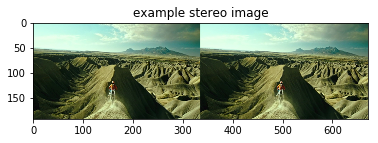

image shape: (192, 672, 3)


In [5]:

stereo_image_files = glob('sample_stereo_images/samples/*')
    
print('found {} images'.format(len(stereo_image_files)))
stereo_im = mpimg.imread(stereo_image_files[10])
plt.imshow(stereo_im)
plt.title('example stereo image')
plt.show()
print('image shape: {}'.format(stereo_im.shape))



img_rows, img_cols = stereo_im.shape[0], stereo_im.shape[1]/2

im_left = stereo_im[:, :img_cols]
im_right = stereo_im[:, img_cols:]

Looking good! 

Now for the neural network itself, two or three strategies possible: 

 * construct one tower per eye, and merge with a concatenation along the feature axis, 
 * or merge the two towers using 3d convolutions, 
 * or initially merge the two input images as 2$\times$ 3(rgb)=6 different channels of a single image and construct a single 2d convolutional tower.

We will try the third option:  our two input images will be a be concatenated along the channel axis to form a single image with 6 channels: rgb left and right eye images.


The neural network architecture used here is inspired by the u-net model (http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/), i.e. a fully convolutional residual learning architecture, with contracting connections from the lower convolutional layers back up to the deconvolution layers. The particularity of U-net was to bring back activation from the lower layers to the higher level, so that, in the case of the nerve segmentation task it was designed for, the network has a highly detailed reference against which to draw the masks deliminating the nerve cross sections. In the case of w-net, the disparities needs to be calculated at the same spatial resolution as the original image, which is intuitively why bringing back up the lower level activations as a template would help.

The architecture is follows:

![alt text](w-net-architecture.png)

In addition to the fact that w-net deals with a pair of stereo images instead of a single image, there are a few additional particularities:

We use **depth wise separable convolutions** in order not to loose the cross channel features (https://arxiv.org/abs/1610.02357). This is espacially needed here as the two images are concatenated along the channel axis and need to stay separable.

Another particulrity of w-net is the presence of both a **probabilistic selection layer**, which uses the calculated disparity to apply geometrical transformations from the left to right images as initially described in [deep3d](https://arxiv.org/abs/1604.03650), as well as a gradient layer which computes the spatial gradient of the calculated disparity map in order to enforce some level of smoothness with the help of an auxiliary loss function.


#### Lets first look building a selection layer. 

Our network predicts a probability distribution across possible disparity values d (with $d \in \left[-16,16 \right]$) at each pixel location $D^{d}_{i,j}$ , where $\sum_{d}P^{d}_{i,j} = 1$ for all $i, j$. To get the right image from the left image and the disparity map, and check that the disparity map is correct, we first define a shifted stack of the left view as $L^{d}_{i,j}= L_{i,j-d}$, then we use the disparity map $D^{d}_{i,j}$ to calculate the right image as:

$$ R_{i,j} = \sum_{d} L^{d}_{i,j} D^{d}_{i,j} \;\;\;\;\;\;\;\;\;\;\;\;   (1)$$

This is differentiable with respect to $D^{d}_{i,j}$. This means that we will be able to train the network using backpropagation to modify the disparity map infered from both the left and right image until it is correct, e.g. we can properly reconstruct the right image from the left image and the disparity map using the equation above.

We create this "geometry expert" layer that will perform the simple operation in eq (1) using tensorflow/keras . This layer will not contain any learnable weight, its output is completely deterministic given an image and a disparity map. Its only role is to contain information about the simple geometric rules that allow one to calculate right image from left and disparity. This infusion of expert knowledge is all the network should need to start being able to compute depth from pairs of images. 

In summary, this layer needs to do the following:

* construct the shifted left image stack $L^{d}_{i,j}= L_{i,j-d}$
* compute the right image by performing a dot product along the disparity values axis $d$ as $ R_{i,j} = \sum_{d} L^{d}_{i,j} D^{d}_{i,j}$


Lets build a custom keras layer that implements these operations:

In [6]:
from keras.engine.topology import Layer
import numpy as np

class Selection(Layer):

    def __init__(self, disparity_levels=None, **kwargs):
        # if none, initialize the disparity levels as described in deep3d
        if disparity_levels is None:
            disparity_levels = range(-16,16,1)
            
        super(Selection, self).__init__(**kwargs)
            
        self.disparity_levels = disparity_levels

    def build(self, input_shape):
        # Used purely for shape validation.
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('A `Selection` layer should be called '
                             'on a list of 2 inputs.')
            

    def call(self, inputs):
        
        # first we extract the left image from the original input
        image = inputs[0]
        # then the calculated disparity map that is the ouput of the Unet
        disparity_map = inputs[1]
        # initialize the stack of shifted left images
        shifted_images = []
        # loop over the different disparity levels and shift the left image accordingly, add it to the list
        for shift in self.disparity_levels:
            if shift > 0:
                shifted_images += [K.concatenate([image[..., shift:,:], K.zeros_like(image[..., :shift,:])], axis=2)]
            elif shift < 0:
                shifted_images += [K.concatenate([K.zeros_like(image[..., shift:,:]), image[..., :shift,:]], axis=2)]
            else:
                shifted_images += [image]
        
        # create a tensor of shape (None, im_rows, im_cols, disparity_levels)
        shifted_images_stack = K.stack(shifted_images)
        shifted_images_stack = K.permute_dimensions(shifted_images_stack, (1,2,3,0,4))
        
        # take the dot product with the disparity map along the disparity axis
        # and output the resulting right image of size (None, im_rows, im_cols)
        new_image = []
        for ch in range(3):
            new_image += [K.sum(shifted_images_stack[...,ch]*disparity_map, axis=3)]
            
        new_image = K.stack(new_image)
        new_image = K.permute_dimensions(new_image, (1,2,3,0))
            
        return new_image

    def compute_output_shape(self, input_shape):
        return input_shape[0]

We test our custom layer by inputing some dummy data and check is the initialization and the call method function as they are supposed to. For that, we use the left image we loaded earlier, and check for a few disparity levels if the image if shifted correctly:
(very slow because of communication overhead between Python and Tensorflow in sess.run, which is executed multiple times inside this simple check snipet)

100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


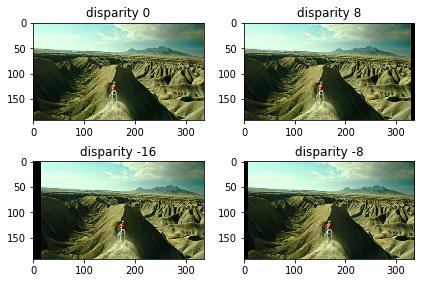

100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


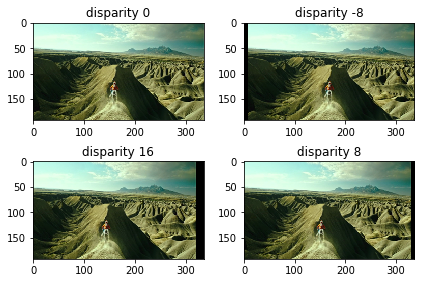

In [7]:
selectLayer = Selection(disparity_levels= range(-16,16,1))
selectLayer.build([(None,img_rows,img_cols,2), (None, img_rows, img_cols,3, 30)])

plt.figure()
for n, disp_level in enumerate(tqdm(range(-16,16,8))):
    disparity = np.zeros((1,img_rows,img_cols,32))
    disparity[...,disp_level] = 1.0
    disparity = K.variable(disparity)
    left_image = K.variable(np.expand_dims(im_left,0).astype('float32'))

    right_im = selectLayer.call([left_image, disparity])
    im_right = K.eval(right_im)
    
    plt.subplot(2,2,n+1)
    plt.imshow(im_right[0])
    plt.title('disparity {}'.format(selectLayer.disparity_levels[disp_level]))
    
plt.tight_layout()
plt.show()

selectLayer = Selection(disparity_levels= range(16,-16,-1))
selectLayer.build([(None,img_rows,img_cols,2), (None, img_rows, img_cols, 12)])

plt.figure()
for n, disp_level in enumerate(tqdm(range(-16,16,8))):
    disparity = np.zeros((1,img_rows,img_cols,32))
    disparity[...,disp_level] = 1.0
    disparity = K.variable(disparity)
    left_image = K.variable(np.expand_dims(im_left,0).astype('float32'))

    right_im = selectLayer.call([left_image, disparity])
    im_right = K.eval(right_im)
    
    plt.subplot(2,2,n+1)
    plt.imshow(im_right[0])
    plt.title('disparity {}'.format(selectLayer.disparity_levels[disp_level]))
    
plt.tight_layout()
plt.show()

Looking great!
Next, we implement a "gradient" layer. Its role is to calculate the spatial gradient of a 2d tensor. It does it using
finite difference and a few simple shifting operations. We output the sum of absolute value of the gradient in the
x and y directions.

In [8]:
from keras.engine.topology import Layer
import numpy as np

class Gradient(Layer):

    def __init__(self, **kwargs):
        # if none, initialize the disparity levels as described in deep3d
        super(Gradient, self).__init__(**kwargs)
            
    def build(self, input_shape):
        # Used purely for shape validation.
        pass

    def call(self, inputs):
        
        dinputs_dx_0 = inputs - K.concatenate( [K.zeros_like(inputs[..., :1,:]), inputs[..., :-1,:]], axis=1)
        dinputs_dx_1 = inputs - K.concatenate( [inputs[..., 1:,:], K.zeros_like(inputs[..., :1,:])], axis=1)
        
        dinputs_dy_0 = inputs - K.concatenate( [K.zeros_like(inputs[..., :1]), inputs[..., :-1]], axis=2)
        dinputs_dy_1 = inputs - K.concatenate( [inputs[..., 1:], K.zeros_like(inputs[..., :1])], axis=2)
        
        abs_gradient_sum = 0.25*K.sqrt(K.square(dinputs_dx_0)+K.square(dinputs_dx_1)+
                                       K.square(dinputs_dy_0)+K.square(dinputs_dy_1))
        
        return abs_gradient_sum[...,2:-2,2:-2]
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1]-4,input_shape[2]-4)

Finally, we construct one last custom layer called a depth layer. This takes in the disaprity maps, and simply sums
them along the disparity levels axis. Its output is a 2d tensor, an image that with value inversely proportional 
to the distance of object to the camera (see [wikipedia_stereovision](https://en.wikipedia.org/wiki/Computer_stereo_vision)).

In [9]:
from keras.engine.topology import Layer
import numpy as np

class Depth(Layer):

    def __init__(self, disparity_levels=None, **kwargs):
        # if none, initialize the disparity levels as described in deep3d
        if disparity_levels is None:
            disparity_levels = range(-3,9,1)
            
        # if none, initialize the disparity levels as described in deep3d
        super(Depth, self).__init__(**kwargs)
        
        self.disparity_levels = disparity_levels
            
    def build(self, input_shape):
        # Used purely for shape validation.
        pass
            

    def call(self, disparity):
        
        depth = []
        for n, disp in enumerate(self.disparity_levels):
            depth += [disparity[...,n]*disp]
        
        depth = K.concatenate(depth, axis=0)
        return K.sum(depth, axis=0, keepdims=True)
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

Looking great! Now let's try to build and compile the entire model:

In [10]:
def get_unet(img_rows, img_cols, lr=1e-4):
    inputs = Input((img_rows, 2 * img_cols, 3))  # 2 channels: left and right images

    # split input left/right wise
    left_input_image = Lambda(lambda x: x[..., :img_cols, :])(inputs)
    right_input_image = Lambda(lambda x: x[..., img_cols:, :])(inputs)

    concatenated_images = concatenate([left_input_image, right_input_image], axis=3)

    conv1 = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(concatenated_images)
    conv1 = BatchNormalization()(conv1)
    conv1 = SeparableConv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = SeparableConv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = SeparableConv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = SeparableConv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(rate=0.4)(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = SeparableConv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(rate=0.4)(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(rate=0.4)(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = SeparableConv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Dropout(rate=0.4)(conv9)

    # split into left/right disparity maps

    left_disparity_level_4 = Conv2DTranspose(32, (16, 16), strides=(16, 16), padding='same')(
        Lambda(lambda x: x[..., 128:])(pool4))
    right_disparity_level_4 = Conv2DTranspose(32, (16, 16), strides=(16, 16), padding='same')(
        Lambda(lambda x: x[..., :128])(pool4))

    left_disparity_level_3 = Conv2DTranspose(32, (8, 8), strides=(8, 8), padding='same')(
        Lambda(lambda x: x[..., 64:])(pool3))
    right_disparity_level_3 = Conv2DTranspose(32, (8, 8), strides=(8, 8), padding='same')(
        Lambda(lambda x: x[..., :64])(pool3))

    left_disparity_level_2 = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(
        Lambda(lambda x: x[..., 32:])(pool2))
    right_disparity_level_2 = Conv2DTranspose(32, (4, 4), strides=(4, 4), padding='same')(
        Lambda(lambda x: x[..., :32])(pool2))

    left_disparity_level_1 = Lambda(lambda x: x[..., :32])(conv9)
    right_disparity_level_1 = Lambda(lambda x: x[..., 32:])(conv9)

    left_disparity = Lambda(lambda x: K.mean(K.stack([xi for xi in x]), axis=0))([left_disparity_level_1,
                                                                                  left_disparity_level_2,
                                                                                  left_disparity_level_3,
                                                                                  left_disparity_level_4])

    right_disparity = Lambda(lambda x: K.mean(K.stack([xi for xi in x]), axis=0))([right_disparity_level_1,
                                                                                   right_disparity_level_2,
                                                                                   right_disparity_level_3,
                                                                                   right_disparity_level_4])

    # use a softmax activation on the conv layer output to get a probabilistic disparity map
    left_disparity = SeparableConv2D(32, (3, 3), activation='softmax', padding='same')(left_disparity)

    right_disparity = SeparableConv2D(32, (3, 3), activation='softmax', padding='same')(right_disparity)

    left_disparity_levels = range(-16, 16, 1)
    right_reconstruct_im = Selection(disparity_levels=left_disparity_levels)([left_input_image, left_disparity])

    right_disparity_levels = range(16, -16, -1)
    left_reconstruct_im = Selection(disparity_levels=right_disparity_levels)([right_input_image, right_disparity])

    # concatenate left and right images along the channel axis
    output = concatenate([left_reconstruct_im, right_reconstruct_im], axis=2)

    # gradient regularization:
    depth_left = Depth(disparity_levels=left_disparity_levels)(left_disparity)
    depth_right = Depth(disparity_levels=left_disparity_levels)(right_disparity)
    depth_left_gradient = Gradient()(depth_left)
    depth_right_gradient = Gradient()(depth_right)

    left_input_im_gray = Lambda(lambda x: K.mean(x, axis=3))(left_input_image)
    right_input_im_gray = Lambda(lambda x: K.mean(x, axis=3))(right_input_image)

    left_input_im_gray_norm = Lambda(lambda x: x / K.max(x))(left_input_im_gray)
    right_input_im_gray_norm = Lambda(lambda x: x / K.max(x))(right_input_im_gray)

    image_left_gradient = Gradient()(left_input_im_gray_norm)
    image_right_gradient = Gradient()(right_input_im_gray_norm)

    weighted_gradient_left = Lambda(lambda x: x[0] * (1 - x[1]))([depth_left_gradient, image_left_gradient])
    weighted_gradient_right = Lambda(lambda x: x[0] * (1 - x[1]))([depth_right_gradient, image_right_gradient])

    model = Model(inputs=[inputs], outputs=[output, weighted_gradient_left, weighted_gradient_right])

    disp_map_model = Model(inputs=[inputs], outputs=[left_disparity, right_disparity])

    # we use L1 type loss as it has been shown to work better for that type of problem in the deep3d paper
    # (https://arxiv.org/abs/1604.03650)
    model.compile(optimizer=Adam(lr=lr), loss='mean_absolute_error', loss_weights=[1., 0.001, 0.001])
    model.summary()

    return model, disp_map_model

The get_unet function output both the w_net model to be trained, as well as a feed forward model that directly returns the depth map, used for inferences (they share the same weights).

In [11]:
K.clear_session()
unet_model, disp_map_model = get_unet(img_rows, img_cols, lr=0.75e-4);

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 192, 672, 3)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 192, 336, 6)   0           lambda_1[0][0]                   
                                                                   lambda_2[0][0]          

In [12]:
disp_map_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 192, 672, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 192, 336, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 192, 336, 6)   0           lambda_1[0][0]                   
                                                                   lambda_2[0][0]          

For the training, we use Keras's image data generator, modified to deal with stereo images. 
The code for training is in the file train_w_net.py. 

Let's load weights from a previously trained w-net, and see what the depth maps look like from the data we have. 

In [13]:
w_net, disp_maps_forward = get_unet(img_rows=img_rows, img_cols=img_cols)
w_net.load_weights('weights/w_net_V12_epoch_14.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 192, 672, 3)   0                                            
____________________________________________________________________________________________________
lambda_20 (Lambda)               (None, 192, 336, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
lambda_19 (Lambda)               (None, 192, 336, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
concatenate_7 (Concatenate)      (None, 192, 336, 6)   0           lambda_19[0][0]                  
                                                                   lambda_20[0][0]         

In [14]:
from data_loader import get_data_generators

data_generator, _ , _, _ = get_data_generators('sample_stereo_images/',
                                                     'sample_stereo_images/', 
                                                     batch_size=1,
                                                    shuffle=False, img_rows=img_rows, img_cols=img_cols)

Found 55 images belonging to 1 classes.
Found 55 images belonging to 1 classes.
Found 55 images belonging to 1 classes.
Found 55 images belonging to 1 classes.


Its not perfect, but its extremely fast on a gpu, and there is a lot of room for improvement, espercially considering that
the network is self-supervised and that there no need for depthmap ground truths, only pairs of stereo images.

  0%|          | 0/1 [00:00<?, ?it/s]

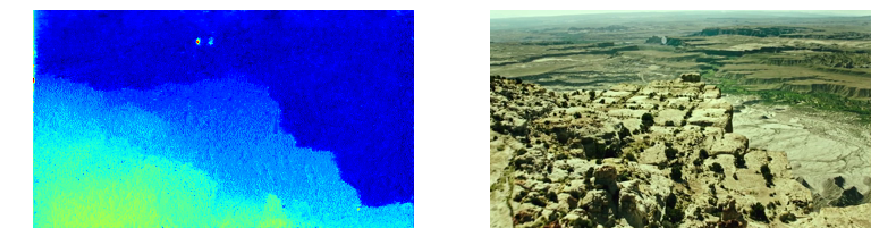

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


In [22]:
images = []
depthmaps = []
for i in tqdm(range(1)):
    dat = data_generator.next()

    disparity_map_left, disparity_map_right = disp_maps_forward.predict(dat[0][0:10])

    depthMap_left = np.zeros(disparity_map_left[0,...,0].shape)
    for i_disp, disp in zip(range(-16,16),np.rollaxis(disparity_map_left[0,...],2)):
        depthMap_left += disp*i_disp

    depthMap_right = np.zeros(disparity_map_right[0,...,0].shape)
    for i_disp, disp in zip(range(-16,16),np.rollaxis(disparity_map_right[0,...],2)):
        depthMap_right += disp*i_disp
        
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,2)
    plt.imshow(dat[0][0,:,:img_cols,:])
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(depthMap_left, cmap=plt.cm.jet)
    plt.axis('off')
    plt.show()
    